# Part III: How to Secure Federated Learning in Network Monitoring

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2025/blob/main/notebooks/part3.ipynb)

In this final part, we will see the security of a federated intrusion detection system. We will use the same dataset as in Part II, but we will now assume that an attacker is now sending malicious updates to negatively impact the system. We will see how the system can be made more robust to such attacks using a modified aggregation algorithm called FoolsGold.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.11.13).
> The present notebook has been designed to work with Python 3.11, and may not work with earlier or later versions.
> Please ensure that you have the correct Python version.

If you are running this notebook in Google Colab, you can install the required dependencies by running the following cell. Otherwise, you can install them in your local environment using `uv` or `pip`.


In [37]:
%load_ext autoreload
%autoreload 2

from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !git clone https://github.com/leolavaur/icdcs_2025
    %pip install -r icdcs_2025/requirements.txt
    !cp -r icdcs_2025/notebooks/utils/ .


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Once you have a working environment, check that everything works, notably your GPU for the TensorFlow backend.
You can do so by running the following cell:

In [38]:
import tensorflow as tf
from IPython.utils import io

with io.capture_output(stdout=False) as _:
    print("TensorFlow version:", tf.__version__)
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")


TensorFlow version: 2.19.0
Num GPUs Available: 0


To allow others to reproduce your results with some degree of certitude, set a seed for all the pseudo-random number generators (PRNG) that you use.
You can also run your threads deterministically, in case your ML backend optimize training.
This will have a negative impact on the performance.


In [39]:
import keras

keras.utils.set_random_seed(1138)

## Section 1: Dataset and model setup

This section is roughly the same as in Part II, and will not be explained in detail. We re-add the corresponding code here, but you can refer to Part II for more details.

In [40]:
BATCH_SIZE = 128
EPOCHS = 5
NUM_CLIENTS = 10
NUM_ROUNDS = 10

In [41]:
from utils.nslkdd import load_nslkdd

dds = load_nslkdd()
dds


Dataset zip already exists.
Dataset already extracted.


DatasetDict({
    train: Dataset({
        features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'binary_label'],
        num_rows: 125973
    })
    test: Dataset({
        features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num

In [42]:
ATTACK_LABELS = dds["train"].features["label"].names
print("Attack labels:", ATTACK_LABELS)
FEATURES = [feat for feat in dds["train"].features if "label" not in feat]
print("Features:", FEATURES)


Attack labels: ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit', 'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack', 'snmpguess', 'spy', 'sqlattack', 'teardrop', 'udpstorm', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop', 'xterm']
Features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate

In [43]:
from datasets import Dataset
import tensorflow as tf


@tf.autograph.experimental.do_not_convert
def dict_to_tensor(features, label):
    """Convert a dictionary of features to a tensor."""
    # Stack all features as float32
    x = tf.stack([tf.cast(features[col], tf.float32) for col in features], axis=-1)
    return x, label


def dataset_to_tf(dataset: Dataset, batch_size: int, shuffle: bool) -> tf.data.Dataset:
    """Convert a Dataset to a tf.data.Dataset."""
    return dataset.to_tf_dataset(
        columns=[col for col in dataset.features if "label" not in col],
        label_cols="binary_label",
        shuffle=shuffle,
        batch_size=batch_size,
    ).map(dict_to_tensor)


In [44]:
import keras
from keras.optimizers import Adam

n_features = len([feat for feat in dds["train"].features if "label" not in feat])
print(n_features)

# Compute mean and std for numerical features
train_numpy = dds["train"].to_pandas()
means = train_numpy[FEATURES].mean().values
stds = train_numpy[FEATURES].std().values


def mk_model() -> keras.Model:
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Normalization(mean=means, variance=stds**2),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )
    return model


mk_model().summary()


41


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_18                │ (None, 41)             │             0 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from typing import cast
from datasets import Dataset
import flwr
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

NUM_ROUNDS = 10


def get_evaluate_fn(testset: Dataset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    history: list[dict[str, float]] = []

    test_tf = dataset_to_tf(testset, batch_size=BATCH_SIZE, shuffle=False)

    # The `evaluate` function will be called after every round by the strategy
    def evaluate_fn(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        if server_round == NUM_ROUNDS:
            # Save final model
            np.save("fl_weights", np.array(parameters, dtype=object))

        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, _ = model.evaluate(test_tf, verbose=cast(str, 0))

        inferences = model.predict(test_tf, verbose=cast(str, 0))
        y_pred = np.round(inferences)
        y_true = np.array(testset["binary_label"])

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        metrics = {
            "accuracy": (tn + tp) / (tn + fp + fn + tp),
            "precision": tp / (tp + fp),
            "recall": tp / (tp + fn),
            "f1": 2 * tp / (2 * tp + fp + fn),
            "miss_rate": fn / (fn + tp),
        }

        history.append(metrics | {"round": server_round, "loss": loss})

        return (loss, metrics)

    return evaluate_fn, history


def eval_model(parameters, testset: Dataset):
    """Evaluate the model with the given parameters on the test dataset."""
    fn, _ = get_evaluate_fn(testset)
    loss, metrics = fn(0, parameters, {})
    return {"loss": loss} | metrics


def eval_classes(parameters, testset):
    """Evaluate the model with the given parameters on the test dataset, per class."""
    model = mk_model()
    model.set_weights(parameters)

    class_array = np.array(testset["label"])
    test_tf = dataset_to_tf(testset, batch_size=BATCH_SIZE, shuffle=False)

    inferences = model.predict(test_tf, verbose=cast(str, 0))
    y_pred = np.round(inferences).reshape(-1)
    y_true = np.array(testset["binary_label"])

    classes_stats = {}
    for cls in set(class_array):
        class_filter = class_array == cls
        count = sum(class_filter)
        if not (count > 0):
            continue
        correct = sum(class_filter & (y_true == y_pred))
        missed = sum(class_filter & (y_true != y_pred))

        classes_stats[cls] = {
            "count": count,
            "correct": correct,
            "missed": missed,
            "rate": correct / count,
        }
    ret = pd.DataFrame(classes_stats).T
    ret.index = [testset.features["label"].int2str(i) for i in ret.index]
    return ret


In [46]:
import flwr
import tensorflow as tf


class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, trainset: tf.data.Dataset):
        keras.utils.set_random_seed(1138)  # In client thread
        self.model = mk_model()
        self.trainset = trainset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=0)
        return self.model.get_weights(), len(self.trainset), {}


In [47]:
from typing import Callable

from flwr.client import Client, ClientApp
from flwr.common import Context
from flwr_datasets.partitioner import Partitioner


def mk_client_fn(
    partitioner: Partitioner,
) -> Callable[[str], Client]:
    """Return a function which creates a new Client for a given partition."""

    def client_fn(context: Context) -> Client:
        """Create a new Client for partition i."""
        partition_id = int(context.node_config["partition-id"])
        client_dataset = partitioner.load_partition(partition_id)
        client_tf = dataset_to_tf(client_dataset, batch_size=BATCH_SIZE, shuffle=True)
        return FlowerClient(trainset=client_tf).to_client()

    return client_fn


In addition to what is done in part I, we will add a function to automate the FL process, as we will have multiple experiments to run in this part.

In [48]:
import os
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerAppComponents, ServerConfig
from flwr.server.strategy import Strategy
from typing import Callable


def mk_server_fn(
    strategy: Strategy,
    num_rounds: int = 10,
) -> Callable[[Context], ServerAppComponents]:
    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_rounds)
        return ServerAppComponents(
            strategy=strategy,
            config=config,
        )

    return server_fn


def fl(
    partitioner: Partitioner,
    testset: Dataset,
    num_clients=NUM_CLIENTS,
    num_rounds=NUM_ROUNDS,
    strategy_class=flwr.server.strategy.FedAvg,
) -> list[dict[str, float]]:
    """Run a FL simulation and return the history of evaluation metrics."""
    evaluate_fn, history = get_evaluate_fn(testset)

    strategy = strategy_class(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.0,  # Disable the federated evaluation
        min_fit_clients=NUM_CLIENTS,  # Always sample all clients
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn,
        initial_parameters=ndarrays_to_parameters(mk_model().get_weights()),
    )

    server_app = flwr.server.ServerApp(server_fn=mk_server_fn(strategy, num_rounds))

    client_fn = mk_client_fn(partitioner)
    client_app = ClientApp(client_fn=client_fn)

    # Enable GPU growth in the main process
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"

    # Start simulation
    flwr.simulation.run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=num_clients,
        backend_config={
            "client_resources": {
                "num_cpus": 2,
                "num_gpus": 0.1
                if len(tf.config.list_physical_devices("GPU")) > 0
                else 0.0,
            }
        },
    )

    return history

Note that the different partitions have different sizes since we are using a non-stratified NIID partitioning. Clients are therefore different in terms of both, the number of samples they have and the distribution of classes in their data.

In [49]:
from flwr_datasets.partitioner import DirichletPartitioner

# partitioner = ClassDropPartitioner(
#     num_partitions=NUM_CLIENTS,
#     partition_by="label",
#     n_drop=4,
#     droppable=[
#         "back",
#         "httptunnel",
#         "ipsweep",
#         "neptune",
#         "portsweep",
#         "saint",
#         "satan",
#         "smurf",
#     ],  # See part II for why we select these classes.
# )
partitioner = DirichletPartitioner(
    num_partitions=NUM_CLIENTS, partition_by="label", alpha=0.9
)
partitioner.dataset = dds["train"]

for i in range(partitioner.num_partitions):
    print(len(partitioner.load_partition(i)))

18848
31345
8791
13071
2660
10340
8972
8025
8086
15835


Finall, we will re-run the training process from Part II to make sure that everything is working as expected, and gather the results.

In [50]:
history_baseline = fl(partitioner, dds["test"])
fl_weights = np.load("fl_weights.npy", allow_pickle=True)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.9987630844116211, {'accuracy': np.float64(0.2897444996451384), 'precision': np.float64(0.27302584606597174), 'recall': np.float64(0.1489908828800748), 'f1': np.float64(0.19278080258116556), 'miss_rate': np.float64(0.8510091171199252)}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=222264) 2025-07-20 07:44:59.740553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=222266) 2025-07-20 07:44:59.789354: E external/local_xla/x

In [51]:
eval_model(fl_weights, dds["test"])

{'loss': 1.4141923189163208,
 'accuracy': np.float64(0.769694819020582),
 'precision': np.float64(0.972074632398369),
 'recall': np.float64(0.613028909841814),
 'f1': np.float64(0.7518876039376852),
 'miss_rate': np.float64(0.3869710901581859)}

In [52]:
eval_classes(fl_weights, dds["test"])

,count,correct,missed,rate
apache2,737.0,122.0,615.0,0.165536
back,359.0,0.0,359.0,0.000000
buffer_overflow,20.0,2.0,18.0,0.100000
ftp_write,3.0,1.0,2.0,0.333333
guess_passwd,1231.0,3.0,1228.0,0.002437
httptunnel,133.0,88.0,45.0,0.661654
imap,1.0,1.0,0.0,1.000000
ipsweep,141.0,139.0,2.0,0.985816
land,7.0,7.0,0.0,1.000000
loadmodule,2.0,0.0,2.0,0.000000


## Section 2: The impact of poisoning

Let's build a poisoning function. This one is quite versatile so you can try the different types of attacks, such as targeted (also called backdoors attacks) or untargeted ones. This function will be reused for the next examples.

In [53]:
from datasets import Dataset, ClassLabel


def poison(ds: Dataset, target: list[str]) -> Dataset:
    """Poison the given dataset by flipping the labels of the given target.

    If target is empty, all samples are poisoned.
    If target is "*", all malicious samples are poisoned.
    Otherwise, only the specified targets are poisoned.

    Parameters
    ----------
    ds : Dataset
        The dataset to poison.
    target : list[str]
        A list of classes to target in the given dataset.
    """
    if len(target) == 0:
        # Poison all samples, i.e. flip all "binary_label" values
        ds = ds.map(lambda x: {"binary_label": x["binary_label"] ^ 1})
    elif target == ["*"]:
        # Poison all malicious samples, i.e. flip all "binary_label" values
        ds = ds.map(lambda x: {"binary_label": 1})
    else:
        # feature = ds.features["label"]
        if isinstance(feature := ds.features["label"], ClassLabel):
            # If the label is a ClassLabel, convert target to indices
            target = [feature.str2int(cls) for cls in target]
        # otherwise, only poison the specified targets
        ds = ds.map(
            lambda x: {
                "binary_label": x["binary_label"] ^ 1
                if x["label"] in target
                else x["binary_label"]
            }
        )
    return ds

### 2.1 Testing poisoning locally

Let's validate the impact our poisoning function locally. We will instantiate a participant with a IID shard to see the impact of the poisoning function. We will compare the results of two clients, one with a clean dataset and one with a poisoned dataset.

In [54]:
shard = partitioner.load_partition(0)
shartd_tf = dataset_to_tf(shard, batch_size=BATCH_SIZE, shuffle=True)

model = mk_model()
model.fit(shartd_tf, epochs=EPOCHS, verbose=1)

eval_model(model.get_weights(), dds["test"])

Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7860 - loss: 0.4399
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9590 - loss: 0.1208
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9716 - loss: 0.0899
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9772 - loss: 0.0710
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9824 - loss: 0.0631


{'loss': 1.4020559787750244,
 'accuracy': np.float64(0.771291696238467),
 'precision': np.float64(0.9688530597288384),
 'recall': np.float64(0.6180939764669212),
 'f1': np.float64(0.754709800190295),
 'miss_rate': np.float64(0.3819060235330788)}

In [55]:
eval_classes(model.get_weights(), dds["test"])

,count,correct,missed,rate
apache2,737.0,92.0,645.0,0.124830
back,359.0,0.0,359.0,0.000000
buffer_overflow,20.0,2.0,18.0,0.100000
ftp_write,3.0,1.0,2.0,0.333333
guess_passwd,1231.0,13.0,1218.0,0.010561
httptunnel,133.0,94.0,39.0,0.706767
imap,1.0,1.0,0.0,1.000000
ipsweep,141.0,139.0,2.0,0.985816
land,7.0,7.0,0.0,1.000000
loadmodule,2.0,0.0,2.0,0.000000


In [56]:
shard_poison = poison(shard, ["neptune"])
shartd_tf_poison = dataset_to_tf(shard_poison, batch_size=BATCH_SIZE, shuffle=True)
model = mk_model()
model.fit(shartd_tf_poison, epochs=EPOCHS, verbose=1)

eval_model(model.get_weights(), dds["test"])

Map:   0%|          | 0/18848 [00:00<?, ? examples/s]

Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8238 - loss: 0.4312
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9423 - loss: 0.1580
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9626 - loss: 0.1155
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9711 - loss: 0.0898
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9754 - loss: 0.0791


{'loss': 3.1678054332733154,
 'accuracy': np.float64(0.5462650816181689),
 'precision': np.float64(0.905607476635514),
 'recall': np.float64(0.2265253642951765),
 'f1': np.float64(0.36240104718568844),
 'miss_rate': np.float64(0.7734746357048236)}

In [57]:
eval_classes(model.get_weights(), dds["test"])

,count,correct,missed,rate
apache2,737.0,0.0,737.0,0.000000
back,359.0,0.0,359.0,0.000000
buffer_overflow,20.0,2.0,18.0,0.100000
ftp_write,3.0,0.0,3.0,0.000000
guess_passwd,1231.0,8.0,1223.0,0.006499
httptunnel,133.0,47.0,86.0,0.353383
imap,1.0,0.0,1.0,0.000000
ipsweep,141.0,139.0,2.0,0.985816
land,7.0,7.0,0.0,1.000000
loadmodule,2.0,0.0,2.0,0.000000


### 2.2 Sybil attack on the FL model

In [58]:
NUM_CLIENTS = 10
NUM_ATTACKERS = 8
TARGET = []


In [59]:
from copy import deepcopy

from utils.partition import MockPartitioner


partitioner = DirichletPartitioner(
    num_partitions=NUM_CLIENTS + 1, partition_by="label", alpha=0.9
)
partitioner.dataset = dds["train"]

partitions = [partitioner.load_partition(i) for i in range(partitioner.num_partitions)]
benign_partitions = partitions[:NUM_CLIENTS]
# Poison the attacker partition
attacker = poison(partitions[-1], TARGET)
attacker_partitions = [deepcopy(attacker) for _ in range(NUM_ATTACKERS)]
partitions = benign_partitions + attacker_partitions

partitioner = MockPartitioner(datasets=partitions)


Map:   0%|          | 0/14614 [00:00<?, ? examples/s]

In [60]:
all(shard.data == attacker.data for shard in attacker_partitions)

True

In [61]:
bad_shard = partitioner.load_partition(NUM_CLIENTS + 1)
assert bad_shard.data == attacker.data

bad_tf = dataset_to_tf(bad_shard, batch_size=BATCH_SIZE, shuffle=True)
model = mk_model()
model.fit(bad_tf, epochs=EPOCHS, verbose=1)
eval_model(model.get_weights(), dds["test"])

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7791 - loss: 0.4957
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9460 - loss: 0.1752
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9621 - loss: 0.1293
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9679 - loss: 0.1112
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9715 - loss: 0.0977


{'loss': 5.018939971923828,
 'accuracy': np.float64(0.24059616749467708),
 'precision': np.float64(0.3547468997763773),
 'recall': np.float64(0.40793267357593704),
 'f1': np.float64(0.37948532076839436),
 'miss_rate': np.float64(0.592067326424063)}

In [62]:
history_poisoned = fl(partitioner, dds["test"], num_clients=NUM_CLIENTS + NUM_ATTACKERS)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
(pid=229394) 2025-07-20 07:49:39.431911: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=229394) 2025-07-20 07:49:39.462626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=229387) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=229387) E0000 00:00:1752990579.454319  229387 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory

In [63]:
weights = np.load("fl_weights.npy", allow_pickle=True)

In [64]:
eval_model(weights, dds["test"])

{'loss': 0.9955823421478271,
 'accuracy': np.float64(0.43577004968062455),
 'precision': np.float64(0.5133538170645238),
 'recall': np.float64(0.1692511493805034),
 'f1': np.float64(0.2545710267229255),
 'miss_rate': np.float64(0.8307488506194967)}

As a reminder, here is the performance of the model before the attack:

In [73]:
history_baseline[-1]


{'accuracy': np.float64(0.769694819020582),
 'precision': np.float64(0.972074632398369),
 'recall': np.float64(0.613028909841814),
 'f1': np.float64(0.7518876039376852),
 'miss_rate': np.float64(0.3869710901581859),
 'round': 10,
 'loss': 1.4141923189163208}

In [66]:
eval_classes(weights, dds["test"])

,count,correct,missed,rate
apache2,737.0,76.0,661.0,0.103121
back,359.0,1.0,358.0,0.002786
buffer_overflow,20.0,4.0,16.0,0.200000
ftp_write,3.0,1.0,2.0,0.333333
guess_passwd,1231.0,60.0,1171.0,0.048741
httptunnel,133.0,56.0,77.0,0.421053
imap,1.0,0.0,1.0,0.000000
ipsweep,141.0,63.0,78.0,0.446809
land,7.0,0.0,7.0,0.000000
loadmodule,2.0,0.0,2.0,0.000000


## Section 3: Protecting against sybils -- FoolsGold

FoolsGold is a modified version of the FedAvg algorithm that is robust to sybil attacks. It is based on the idea that sybils will have a different gradient than honest clients, and that we can detect them by looking at the gradient distribution. 

FoolsGold works on the assumption that sybils are orchestrated by a single attacker, and therefore have similar gradient updates.

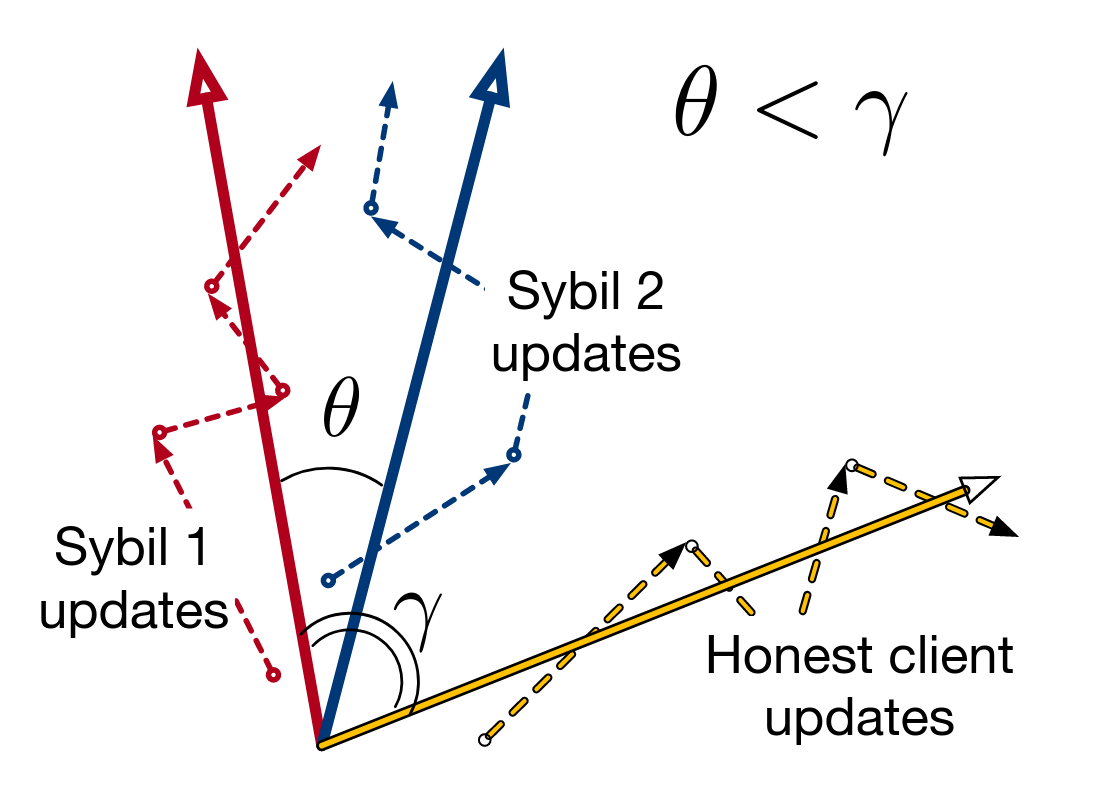

In [67]:
from typing import Optional, Union

import sklearn.metrics.pairwise as smp
from flwr.common import (
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate
from flwr.common.typing import NDArray


def foolsgold(grads: NDArray) -> NDArray:
    """FoolsGold algorithm.

    The content of this function is based on the original implementation of FoolsGold
    devilvered by the authors of the paper. The function is only slightly modified to
    provide explicit typing annotations.

    Link to FoolsGold's repository:
    https://github.com/DistributedML/FoolsGold/blob/master/deep-fg/fg/foolsgold.py

    Parameters
    ----------
        grads (NDArray): A list of historically aggregated gradients, each gradient
            being a list of layers as numpy arrays. Unlike in the original
            implementation, gradients here are the difference between w_i^r and
            w_0^{r-1}, not the gradients themselves.

    Returns>
    -------
        A list of weights, one for each client. The sum of the weights must be 1.

    """
    n_clients = grads.shape[0]
    cs: NDArray = smp.cosine_similarity(grads) - np.eye(n_clients)
    maxcs: NDArray = np.max(cs, axis=1)
    # pardoning
    for i in range(n_clients):
        for j in range(n_clients):
            if i == j:
                continue
            if maxcs[i] < maxcs[j]:
                cs[i][j] = cs[i][j] * maxcs[i] / maxcs[j]
    wv: NDArray = 1 - (np.max(cs, axis=1))
    wv[wv > 1] = 1
    wv[wv < 0] = 0

    # Rescale so that max value is wv
    wv = wv / np.max(wv)
    wv[(wv == 1)] = 0.99

    # Logit function
    wv = np.log(wv / (1 - wv)) + 0.5
    wv[(np.isinf(wv) + wv > 1)] = 1
    wv[(wv < 0)] = 0

    return wv


def flatten_model(model: list[NDArray]) -> NDArray:
    """Flatten the model into a 1D array.

    Arguments:
    ---------
        model: A list of numpy arrays.

    Returns
    -------
        The flattened model.

    """
    return np.concatenate([layer.ravel() for layer in model])


class FoolsGold(FedAvg):
    def __init__(self, *args, **kwargs) -> None:
        """Initialize simulation strategy."""
        assert "initial_parameters" in kwargs, "initial_parameters must be provided"
        # Each client has a history of its flattened gradients at each round
        self.history: dict[str, NDArray] = {}
        self.global_model = parameters_to_ndarrays(kwargs["initial_parameters"])

        super().__init__(*args, **kwargs)

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """Aggregate fit using FoolsGold algorithm.

        FoolsGold

        Arguments:
        ---------
            server_round: The current round of the server.
            results: A list of tuples containing the client and the result of
                the fit operation.
            failures: A list of tuples containing the client and the result of
                the fit operation or the exception raised during the fit
                operation.

        Returns
        -------
            A tuple containing the aggregated parameters and the metrics.

        """
        # Call super method to save client states
        _, _ = super().aggregate_fit(server_round, results, failures)

        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Get results and sort them by client ids
        client_results = [
            (
                proxy.cid,
                parameters_to_ndarrays(fit_res.parameters),
                fit_res.num_examples,
            )
            for proxy, fit_res in results
        ]
        client_results.sort(key=lambda x: x[0])

        # Update history
        for cid, m, _ in client_results:
            grads = flatten_model(m) - flatten_model(self.global_model)
            if cid not in self.history:
                self.history[cid] = np.zeros_like(grads)
            self.history[cid] += grads

        # Get a NDArray of shape (num_clients, num_parameters) with flattened models
        model_updates = np.array(
            [g for _, g in sorted(self.history.items(), key=lambda x: x[0])]
        )

        weights = foolsgold(model_updates)

        weights_results = [(p, w) for (_, p, _), w in zip(client_results, weights)]

        agg = aggregate(weights_results)
        self.global_model = agg

        parameters_aggregated = ndarrays_to_parameters(agg)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)

        return parameters_aggregated, metrics_aggregated

In [68]:
history_fg = fl(
    partitioner,
    dds["test"],
    num_clients=NUM_CLIENTS + NUM_ATTACKERS,
    strategy_class=FoolsGold,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.6282600164413452, {'accuracy': np.float64(0.6929559971611071), 'precision': np.float64(0.9122611242851165), 'recall': np.float64(0.5096236265877035), 'f1': np.float64(0.6539346065393461), 'miss_rate': np.float64(0.4903763734122964)}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 18 clients (out of 18)
(pid=239044) 2025-07-20 07:55:11.898955: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=239044) 2025-07-20 07:55:11.928973: E external/local_xla/xla

In [69]:
weights = np.load("fl_weights.npy", allow_pickle=True)

In [70]:
eval_model(weights, dds["test"])

{'loss': 1.0984413623809814,
 'accuracy': np.float64(0.7803850248403122),
 'precision': np.float64(0.9657291420467975),
 'recall': np.float64(0.6367957609288553),
 'f1': np.float64(0.7675041089457619),
 'miss_rate': np.float64(0.3632042390711447)}

In [71]:
eval_classes(weights, dds["test"])

,count,correct,missed,rate
apache2,737.0,133.0,604.0,0.180461
back,359.0,11.0,348.0,0.030641
buffer_overflow,20.0,3.0,17.0,0.150000
ftp_write,3.0,1.0,2.0,0.333333
guess_passwd,1231.0,24.0,1207.0,0.019496
httptunnel,133.0,112.0,21.0,0.842105
imap,1.0,1.0,0.0,1.000000
ipsweep,141.0,139.0,2.0,0.985816
land,7.0,7.0,0.0,1.000000
loadmodule,2.0,1.0,1.0,0.500000


Text(0.5, 1.0, 'Baseline vs. Poisoned vs. Foolsgold \n 10 clients with 10 clients per round')

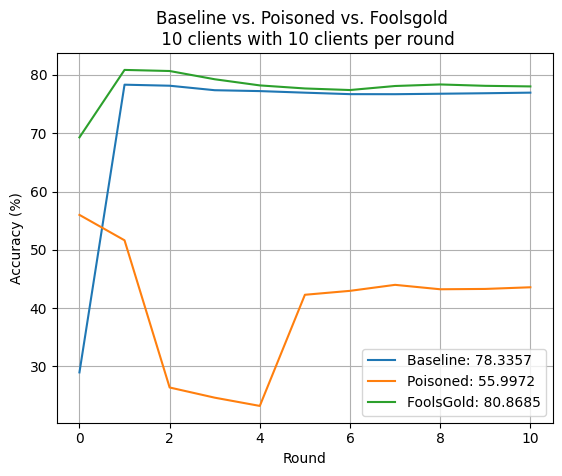

In [72]:
import matplotlib.pyplot as plt

round = [data["round"] for data in history_baseline]
acc_baseline = [100.0 * data["accuracy"] for data in history_baseline]

plt.plot(round, acc_baseline, label=f"Baseline: {max(acc_baseline):.4f}")

acc_poisoned = [100.0 * data["accuracy"] for data in history_poisoned]

plt.plot(round, acc_poisoned, label=f"Poisoned: {max(acc_poisoned):.4f}")

acc_fg = [100.0 * data["accuracy"] for data in history_fg]

plt.plot(round, acc_fg, label=f"FoolsGold: {max(acc_fg):.4f}")

plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("Baseline vs. Poisoned vs. Foolsgold \n 10 clients with 10 clients per round")